In [11]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def fileList(path_before):
    file_list = os.listdir(path_before)
    names = []
    for file in file_list:
        names.append(file)
    names.sort()
    return names


In [10]:
os.listdir('MVTec_grid')

['bent', 'broken', 'glue', 'good', 'metal_contamination', 'thread']

In [7]:
fileList('MVTec_grid')

['bent', 'broken', 'glue', 'good', 'metal_contamination', 'thread']

In [85]:
import numpy as np
good = []
good_label = []
bad = []
bad_label = []

for type in fileList('MVTec_grid'):
    if type == 'good':
        for name in fileList('MVTec_grid/good'):
            good.append(plt.imread('MVTec_grid/good/'+name))
            good_label.append(0)

    else:
        for name in fileList('MVTec_grid/' + type):
            bad.append(plt.imread('MVTec_grid/'+type+'/'+name))
            bad_label.append(1)

good_original = good
bad_original = bad

good = np.array(good)
bad = np.array(bad)

In [114]:
import numpy as np
height = 256
width = 256

resized_good = []
for image in good_original:
    re_image = cv2.resize(image, (width, height))
    resized_good.append(re_image)

resized_bad = []
for image in bad_original:
    re_image = cv2.resize(image, (width, height))
    resized_bad.append(re_image)

resized_good = np.array(resized_good)
resized_bad = np.array(resized_bad)
print(resized_good.shape)
print(resized_bad.shape)

(264, 256, 256)
(57, 256, 256)


In [115]:
good = np.expand_dims(resized_good, axis=-1)
bad = np.expand_dims(resized_bad, axis=-1)

In [116]:
print(good.shape)
print(bad.shape)

(264, 256, 256, 1)
(57, 256, 256, 1)


In [117]:
# good 레이블들을 numpy 배열로 변환
good_label = np.zeros(len(good), dtype=int)
# bad 레이블들을 numpy 배열로 변환
bad_label = np.ones(len(bad), dtype=int)

# 모든 이미지들을 하나로 합치기
all_images = np.concatenate((good, bad), axis=0)

# 모든 레이블들을 하나로 합치기
all_labels = np.concatenate((good_label, bad_label), axis=0)

In [118]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=0)

In [153]:
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=30)

# 데이터가 골고루 섞였는지 확인
print("Train Set Label Distribution:")
print(pd.Series(y_train).value_counts())
print("Test Set Label Distribution:")
print(pd.Series(y_test).value_counts())

Train Set Label Distribution:
0    206
1     50
Name: count, dtype: int64
Test Set Label Distribution:
0    58
1     7
Name: count, dtype: int64


In [154]:
x_train.shape

(256, 256, 256, 1)

In [155]:
y_train.shape

(256,)

- 채널차원
- 트레인 테스트 골고루 해야 함(bent, glue..)

In [156]:
from tensorflow.keras import layers, Model

channels = 1

inputs = layers.Input(shape=(height, width, channels))

# Body
x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Conv2D(64, (3, 3), padding='same')(inputs)
x = layers.MaxPooling2D((2, 2), strides=2)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# x = layers.Conv2D(128, (3, 3), padding='same')(inputs)
# x = layers.MaxPooling2D((2, 2), strides=2)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

# Neck
x = layers.GlobalMaxPooling2D()(x)

# Header
# x = layers.Dense(64)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)
# x = layers.Dropout(0.2)(x)

x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_31 (Conv2D)          (None, 256, 256, 64)      640       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_51 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_51 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 global_max_pooling2d_12 (Gl  (None, 64)               0  

In [157]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=300, callbacks=[es_callback])

Epoch 1/300
13/13 [==============================] - 1s 70ms/step - loss: 0.9161 - acc: 0.3676 - val_loss: 0.6883 - val_acc: 0.7115
Epoch 2/300
13/13 [==============================] - 1s 62ms/step - loss: 0.8307 - acc: 0.3873 - val_loss: 0.6396 - val_acc: 0.8077
Epoch 3/300
13/13 [==============================] - 1s 61ms/step - loss: 0.7182 - acc: 0.5098 - val_loss: 0.5883 - val_acc: 0.8077
Epoch 4/300
13/13 [==============================] - 1s 61ms/step - loss: 0.6618 - acc: 0.6127 - val_loss: 0.5440 - val_acc: 0.8077
Epoch 5/300
13/13 [==============================] - 1s 62ms/step - loss: 0.5817 - acc: 0.6912 - val_loss: 0.5110 - val_acc: 0.8077
Epoch 6/300
13/13 [==============================] - 1s 62ms/step - loss: 0.5359 - acc: 0.7598 - val_loss: 0.4939 - val_acc: 0.8077
Epoch 7/300
13/13 [==============================] - 1s 61ms/step - loss: 0.5166 - acc: 0.8235 - val_loss: 0.4896 - val_acc: 0.8077
Epoch 8/300
13/13 [==============================] - 1s 62ms/step - loss: 0.

In [158]:
p_test = model.predict(x_test)
p_test

3/3 [==============================] - 0s 30ms/step


array([[0.18335895],
       [0.18037803],
       [0.18386567],
       [0.18812491],
       [0.18303981],
       [0.18202332],
       [0.18346478],
       [0.18661934],
       [0.18047577],
       [0.1868348 ],
       [0.1820625 ],
       [0.183067  ],
       [0.17745121],
       [0.18496706],
       [0.18294966],
       [0.17962737],
       [0.1864846 ],
       [0.18983097],
       [0.18356968],
       [0.1853312 ],
       [0.18943691],
       [0.18679982],
       [0.18387063],
       [0.18906291],
       [0.18242802],
       [0.18719256],
       [0.18647654],
       [0.18132591],
       [0.18507245],
       [0.18972744],
       [0.18761636],
       [0.18426381],
       [0.18320878],
       [0.18425219],
       [0.1830598 ],
       [0.18363132],
       [0.18494402],
       [0.18849716],
       [0.1870157 ],
       [0.1804222 ],
       [0.18293564],
       [0.18942687],
       [0.18518223],
       [0.18010147],
       [0.1859918 ],
       [0.18062966],
       [0.18239255],
       [0.183

정확도 : 0.8923076923076924
f1 : 0.0


<Figure size 640x480 with 0 Axes>

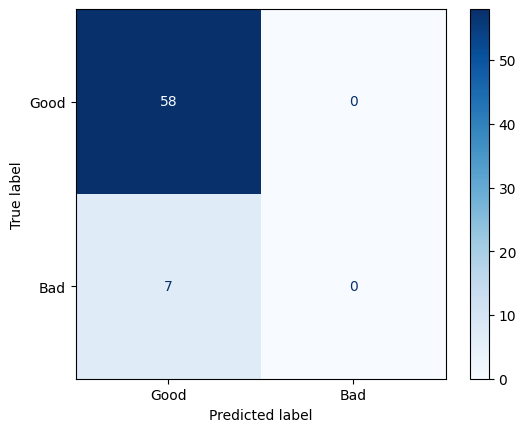

In [159]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

p_test_bin = p_test>=0.5

print('정확도 :', accuracy_score(y_test, p_test_bin))
print('f1 :', f1_score(y_test, p_test_bin))

plt.figure()
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, p_test_bin), display_labels=['Good', 'Bad']).plot(cmap='Blues')
plt.show()
